In [26]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct  4 14:33:21 2019

@author: Theo
"""


import numpy as np
from numpy.fft import rfft2, irfft2
import openpiv.windef as windef
from skimage.util import random_noise
from skimage import img_as_ubyte




# this test are created only to test the displacement evaluation of the
# function the validation methods are not tested here ant therefore
# are disabled.

In [27]:
def create_pair(image_size=32, u=3, v=2):
    """ creates a pair of images with a roll/shift """
    frame_a = np.zeros((image_size, image_size))
    frame_a = random_noise(frame_a)
    frame_a = img_as_ubyte(frame_a)
    # note rolling positive vertical +2 means we create
    # negative vertical velocity as our origin is at 0,0
    # bottom left corner, and the image is rolled from the
    # top left corner

    frame_b = np.roll(np.roll(frame_a, u, axis=1), v, axis=0)
    return frame_a.astype(np.int32), frame_b.astype(np.int32)


frame_a, frame_b = create_pair(image_size=32)

In [28]:
import matplotlib.pyplot as plt

In [29]:
def fft_correlate(window_a, window_b):
    """ FFT based cross correlation
    it is a so-called linear convolution based,
    since we increase the size of the FFT to
    reduce the edge effects.

    This should also work out of the box for rectangular windows.

    Parameters
    ----------
    window_a : 2d np.ndarray
        a two dimensions array for the first interrogation window,

    window_b : 2d np.ndarray
        a two dimensions array for the second interrogation window.

    # from Stackoverflow:
    from scipy import linalg
    import numpy as np

    # works for rectangular windows as well

    x = [[1 , 0 , 0 , 0] , [0 , -1 , 0 , 0] , [0 , 0 , 3 , 0] ,
        [0 , 0 , 0 , 1], [0 , 0 , 0 , 1]]
    x = np.array(x,dtype=np.float)
    y = [[4 , 5] , [3 , 4]]
    y = np.array(y)
    print ("conv:" ,  signal.convolve2d(x , y , 'full'))
    s1 = np.array(x.shape)
    s2 = np.array(y.shape)
    size = s1 + s2 - 1
    fsize = 2 ** np.ceil(np.log2(size)).astype(int)
    fslice = tuple([slice(0, int(sz)) for sz in size])
    new_x = np.fft.fft2(x , fsize)
    new_y = np.fft.fft2(y , fsize)
    result = np.fft.ifft2(new_x*new_y)[fslice].copy()
    print("fft for my method:" , np.array(result.real, np.int32))
    """
    s1 = np.array(window_a.shape)
    s2 = np.array(window_b.shape)
    size = s1 + s2 - 1
    fsize = 2 ** np.ceil(np.log2(size)).astype(int)
    fslice = tuple([slice(0, int(sz)) for sz in size])
    f2a = rfft2(window_a, fsize)
    f2b = rfft2(window_b[::-1, ::-1], fsize)
    corr = irfft2(f2a * f2b).real[fslice]
    return corr

In [121]:
window_a = cor_win_1[0]
window_b = cor_win_2[0]
s1 = np.array(window_a.shape)
s2 = np.array(window_b.shape)
size = s1 + s2 - 1
fsize = 2 ** np.ceil(np.log2(size)).astype(int)
fslice = tuple([slice(0, int(sz)) for sz in size])
f2a = rfft2(window_a, fsize)
f2b = rfft2(window_b[::-1, ::-1], fsize)
corr = irfft2(f2a * f2b).real[fslice]

In [122]:
corr.shape

(31, 31)

In [159]:
def fft_correlate_strided_images(image_a, image_b):
    """ FFT based cross correlation
    of two images with multiple views of np.stride_tricks()
    
    The 2D FFT should be applied to the last two axes (-2,-1) and the
    zero axis is the number of the interrogation window

    This should also work out of the box for rectangular windows.

    Parameters
    ----------
    image_a : 3d np.ndarray, first dimension is the number of windows,
        and two last dimensions are interrogation windows of the first image
    image_b : similar
    """
    s1 = np.array(image_a.shape[-2:])
    s2 = np.array(image_b.shape[-2:])
    size = s1 + s2 - 1
    fsize = 2 ** np.ceil(np.log2(size)).astype(int)
    fslice = tuple([slice(0,image_a.shape[0])] + [slice(0, int(sz)) for sz in size])
    f2a = rfft2(image_a, fsize, axes=(-2,-1))
    f2b = rfft2(image_b[::-1, ::-1], fsize, axes=(-2,-1))
    corr = irfft2(f2a * f2b, axes=(-2,-1)).real[fslice]
    return corr

In [160]:
fft_correlate_strided_images(cor_win_1,cor_win_2).shape

(9, 31, 31)

In [161]:
corr = irfft2(f2a * f2b, axes=(-2,-1)).real

In [147]:
fslice

(slice(0, 9, None), slice(0, 31, None), slice(0, 31, None))

In [151]:
corr[fslice].shape

(9, 31, 31)

In [103]:
tuple([slice(0, int(sz)) for sz in size])

(slice(0, 31, None), slice(0, 31, None))

In [34]:
# simple test of fft_correlate
x = [[1 , 0 , 0 , 0] , [0 , -1 , 0 , 0] , [0 , 0 , 3 , 0] ,
    [0 , 0 , 0 , 1], [0 , 0 , 0 , 1]]
x = np.array(x,dtype=np.float)
y = [[4 , 5] , [3 , 4]]
y = np.array(y)

np.array(fft_correlate(x,y[::-1,::-1]),np.int32)

array([[ 4,  5,  0,  0,  0],
       [ 3,  0, -5,  0,  0],
       [ 0, -3,  7, 15,  0],
       [ 0,  0,  9, 16,  5],
       [ 0,  0,  0,  7,  9],
       [ 0,  0,  0,  3,  4]], dtype=int32)

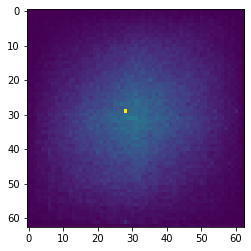

In [37]:
plt.imshow(fft_correlate(frame_a,frame_b))

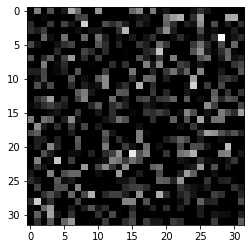

In [31]:
plt.imshow(frame_b,cmap=plt.cm.gray)

In [73]:
from numpy.fft import fftshift

def correlation_func(cor_win_1, cor_win_2, window_size,correlation_method='circular'):
    '''This function is doing the cross-correlation. Right now circular cross-correlation
    That means no zero-padding is done
    the .real is to cut off possible imaginary parts that remains due to finite numerical accuarcy
     '''
    if correlation_method=='linear':
        cor_win_1 = cor_win_1-cor_win_1.mean(axis=(1,2)).reshape(cor_win_1.shape[0],1,1)
        cor_win_2 = cor_win_2-cor_win_2.mean(axis=(1,2)).reshape(cor_win_1.shape[0],1,1)
        cor_win_1[cor_win_1<0]=0
        cor_win_2[cor_win_2<0]=0

     
        corr = fftshift(irfft2(np.conj(rfft2(cor_win_1,s=(2*window_size,2*window_size))) *
                                  rfft2(cor_win_2,s=(2*window_size,2*window_size))).real, axes=(1, 2))
        corr=corr[:,window_size//2:3*window_size//2,window_size//2:3*window_size//2]
        
    else:
        corr = fftshift(irfft2(np.conj(rfft2(cor_win_1)) *
                                  rfft2(cor_win_2)).real, axes=(1, 2))
    return corr

In [74]:
cor_win_1 = moving_window_array(frame_a, 16, 8)
cor_win_2 = moving_window_array(frame_b, 16, 8)


In [86]:
cor_win_1 = cor_win_1-cor_win_1.mean(axis=(1,2)).reshape(cor_win_1.shape[0],1,1)
cor_win_1.mean(axis=(1,2)).reshape(cor_win_1.shape[0],1,1).shape

(9, 1, 1)

In [95]:
irfft2(cor_win_1,s=(2*16,2*16)).shape

(9, 32, 32)

In [94]:
rfft2(np.ones((3,2,2))).

(3, 2, 2)

In [77]:
correlation_func(cor_win_1,cor_win_2,16)

array([[[22201., 24508., 17522., ..., 21122., 13743., 20038.],
        [18487., 20634., 23384., ..., 22332., 22692., 19664.],
        [21396., 18939., 18812., ..., 23960., 24970., 15914.],
        ...,
        [20692., 18915., 22248., ..., 24017., 20605., 16914.],
        [18813., 15736., 21303., ..., 21128., 18737., 19444.],
        [24291., 20715., 23273., ..., 19528., 21124., 22327.]],

       [[25286., 25419., 29155., ..., 24887., 21631., 20478.],
        [28119., 26976., 26635., ..., 19033., 27100., 26646.],
        [21193., 27510., 30132., ..., 26403., 25409., 26660.],
        ...,
        [28969., 28184., 22127., ..., 23705., 22425., 27567.],
        [21315., 26679., 28738., ..., 30594., 24013., 19469.],
        [26710., 22353., 29798., ..., 29082., 27360., 27561.]],

       [[33114., 35552., 33125., ..., 39002., 28468., 33314.],
        [36225., 30693., 28575., ..., 27460., 24882., 38320.],
        [30875., 32408., 40616., ..., 35772., 35823., 34117.],
        ...,
        [343

In [60]:
from openpiv.pyprocess import moving_window_array, get_field_shape, get_coordinates, correlate_windows

def first_pass(
    frame_a,
    frame_b,
    window_size,
    overlap,
    iterations,
    correlation_method="circular",
    subpixel_method="gaussian",
    do_sig2noise=False,
    sig2noise_method="peak2peak",
    sig2noise_mask=2,
):
    """
    First pass of the PIV evaluation.

    This function does the PIV evaluation of the first pass. It returns
    the coordinates of the interrogation window centres, the displacment
    u and v for each interrogation window as well as the mask which indicates
    wether the displacement vector was interpolated or not.


    Parameters
    ----------
    frame_a : 2d np.ndarray
        the first image

    frame_b : 2d np.ndarray
        the second image

    window_size : int
         the size of the interrogation window

    overlap : int
        the overlap of the interrogation window, typically it is window_size/2

    subpixel_method: string
        the method used for the subpixel interpolation.
        one of the following methods to estimate subpixel location of the peak:
        'centroid' [replaces default if correlation map is negative],
        'gaussian' [default if correlation map is positive],
        'parabolic'

    Returns
    -------
    x : 2d np.array
        array containg the x coordinates of the interrogation window centres

    y : 2d np.array
        array containg the y coordinates of the interrogation window centres

    u : 2d np.array
        array containing the u displacement for every interrogation window

    u : 2d np.array
        array containing the u displacement for every interrogation window

    """

    cor_win_1 = moving_window_array(frame_a, window_size, overlap)
    cor_win_2 = moving_window_array(frame_b, window_size, overlap)
    """Filling the interrogation window. They windows are arranged
    in a 3d array with number of interrogation window *window_size*window_size
    this way is much faster then using a loop"""

    correlation = correlate_windows(cor_win_1, cor_win_2,
                                    correlation_method=correlation_method)
    "do the correlation"
    # create a dummy for the loop to fill
    disp = np.zeros((np.size(correlation, 0), 2))
    for i in range(0, np.size(correlation, 0)):
        """ determine the displacment on subpixel level """
        disp[i, :] = find_subpixel_peak_position(
            correlation[i, :, :], subpixel_method=subpixel_method
        )
    "this loop is doing the displacment evaluation for each window "

    shapes = np.array(get_field_shape(frame_a.shape, window_size, overlap))
    u = disp[:, 1].reshape(shapes)
    v = -disp[:, 0].reshape(shapes)
    "reshaping the interrogation window to vector field shape"

    x, y = get_coordinates(frame_a.shape, window_size, overlap)
    "get coordinates for to map the displacement"
    if do_sig2noise is True and iterations == 1:
        sig2noise_ratio = sig2noise_ratio_function(
            correlation, sig2noise_method=sig2noise_method,
            width=sig2noise_mask
        )
        sig2noise_ratio = sig2noise_ratio.reshape(shapes)
    else:
        sig2noise_ratio = np.full_like(u, np.nan)
    return x, y, u, v, sig2noise_ratio

In [68]:
cor_win_1 = moving_window_array(frame_b, 16, 8)

(9, 16, 16)

In [61]:
# circular cross correlation
def test_first_pass_circ():
    """ test of the first pass """
    x, y, u, v, s2n = first_pass(frame_a, frame_b,
                                        window_size=16,
                                        overlap=8,
                                        iterations=1,
                                        correlation_method='circular',
                                        subpixel_method='gaussian',
                                        do_sig2noise=True,
                                        sig2noise_method='peak2peak',
                                        sig2noise_mask=2)
    # print u,v
    assert(np.max(np.abs(u-3)) < 0.1)
    assert(np.max(np.abs(v+2)) < 0.1)

In [62]:
test_first_pass_circ()

ValueError: Shape and axes have different lengths.

In [63]:
def test_multi_pass_circ():
    """ test fot the multipass """
    window_size = (128, 64, 32)
    overlap = (64, 32, 16)
    iterations = 3

    x, y, u, v, s2n = windef.first_pass(frame_a, frame_b, window_size[0],
                                        overlap[0], iterations,
                                        correlation_method='circular',
                                        subpixel_method='gaussian',
                                        do_sig2noise=True,
                                        sig2noise_method='peak2peak',
                                        sig2noise_mask=2)
    u_old = u.copy()
    v_old = v.copy()
    i = 1
    for i in range(2, iterations+1):
        x, y,\
        u, v,\
        s2n, mask = windef.multipass_img_deform(frame_a, frame_b,
                                                window_size[i-1], overlap[i-1],
                                                iterations, i, x, y, u, v,
                                                correlation_method='circular',
                                                subpixel_method='gaussian',
                                                do_sig2noise=False,
                                                sig2noise_method='peak2peak',
                                                sig2noise_mask=2,
                                                MinMaxU=(-100, 50),
                                                MinMaxV=(-50, 50),
                                                std_threshold=1000000,
                                                median_threshold=200000,
                                                median_size=1,
                                                filter_method='localmean',
                                                max_filter_iteration=10,
                                                filter_kernel_size=2,
                                                interpolation_order=3)
    assert(np.max(np.abs(u-3)) < 0.1 and np.any(u != u_old))
    assert(np.max(np.abs(v+2)) < 0.1 and np.any(v != v_old))
    # the second condition is to check if the multipass is done.
    # It need's a little numerical inaccuracy.


# linear cross correlation
def test_first_pass_lin():
    """ test of the first pass """
    x, y, u, v, s2n = windef.first_pass(frame_a, frame_b, window_size=64,
                                        overlap=32, iterations=1,
                                        correlation_method='linear',
                                        subpixel_method='gaussian',
                                        do_sig2noise=True,
                                        sig2noise_method='peak2peak',
                                        sig2noise_mask=2)
    # print u,v
    assert(np.max(np.abs(u-3)) < 0.1)
    assert(np.max(np.abs(v+2)) < 0.1)


def test_multi_pass_lin():
    """ test fot the multipass """
    window_size = (128, 64, 32)
    overlap = (64, 32, 16)
    iterations = 3

    x, y, u, v, s2n = windef.first_pass(frame_a, frame_b, window_size[0],
                                        overlap[0], iterations,
                                        correlation_method='linear',
                                        subpixel_method='gaussian',
                                        do_sig2noise=True,
                                        sig2noise_method='peak2peak',
                                        sig2noise_mask=2)
    u_old = u.copy()
    v_old = v.copy()
    i = 1
    for i in range(2, iterations+1):
        x, y,\
        u, v,\
        sn, m = windef.multipass_img_deform(frame_a, frame_b,
                                            window_size[i-1],
                                            overlap[i-1],
                                            iterations, i, x, y,
                                            u, v,
                                            correlation_method='linear',
                                            subpixel_method='gaussian',
                                            do_sig2noise=False,
                                            sig2noise_method='peak2peak',
                                            sig2noise_mask=2,
                                            MinMaxU=(-100, 50),
                                            MinMaxV=(-50, 50),
                                            std_threshold=1000000,
                                            median_threshold=200000,
                                            median_size=1,
                                            filter_method='localmean',
                                            max_filter_iteration=10,
                                            filter_kernel_size=2,
                                            interpolation_order=3)
    assert(np.max(np.abs(u-3)) < 0.1 and np.any(u != u_old))
    assert(np.max(np.abs(v+2)) < 0.1 and np.any(v != v_old))
    # the second condition is to check if the multipass is done.
    # It need's a little numerical inaccuracy.